# Sign Language Image Classification using Deep Learning

## Overview

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The main aims of the assignment are:

 - To implement and train different types of deep learning network;
 
 - To systematically optimise the architecture and parameters of the networks;
  
 - To explore over-fitting and know what appropriate actions to take in these cases.
 

It is the intention that this assignment will take you through the process of implementing and optimising deep learning approaches. The way that you work is more important than the results for this assignment, as what is most crucial for you to learn is how to take a dataset, understand the problem, write appropriate code, optimize performance and present results. A good understanding of the different aspects of this process and how to put them together well (which will not always be the same, since different problems come with different constraints or difficulties) is the key to being able to effectively use deep learning techniques in practice.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.


## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled data of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 50 training runs in total** (including all models and hyperparameter settings that you consider).  

In addition, you are told to **create a validation set and any necessary test sets using _only_ the supplied testing dataset.** It is unusual to do this, but here the training set contains a lot of non-independent, augmented images and it is important that the validation images must be totally independent of the training data and not made from augmented instances of training images.

The clients have asked to be informed about the following:
 - **unbiased accuracy** estimate of a deep learning model (since DL models are fast when deployed)
 - the letter with the lowest individual accuracy
 - the most common error (of one letter being incorrectly labelled as another)
 
Your manager has asked you to create a jupyter notebook that shows the following:
 - loading the data, checking it, fixing any problems, and displaying a sample
 - training and optimising both **densely connected** *and* **CNN** style models
 - finding the best one, subject to a rapid turn-around and corresponding limit of 50 training runs in total
 - reporting clearly what networks you have tried, the method you used to optimise them, the associated learning curves, their summary performance and selection process to pick the best model
     - this should be clear enough that another employee, with your skillset, should be able to take over from you and understand your methods
 - results from the model that is selected as the best, showing the information that the clients have requested
 - a statistical test between the best and second-best models, to see if there is any significant difference in performance (overall accuracy)
 - it is hoped that the accuracy will exceed 96% overall and better than 90% for every individual letter, and you are asked to:
     - report the overall accuracy
     - report the accuracy for each individual letter
     - write a short recommendation regarding how likely you think it is to achieve these goals either with the current model or by continuing to do a small amount of model development/optimisation


## Part 1
### 1.1 Loading

In [226]:
# Invkoing necessary libraries
import numpy as np
import pandas as pd
import os, time
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import to_categorical

In [227]:
# Reading the train and test files
train_hand_sign_df = pd.read_csv("sign_mnist_train.csv")
test_hand_sign_df = pd.read_csv("sign_mnist_test.csv")

# Displaying first 5 train dataset
train_hand_sign_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [228]:
# Displaying all datatypes of each feature in the dataset
train_hand_sign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [229]:
# Checking for any null values in the record
train_hand_sign_df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [230]:
# Train dataset summary
train_hand_sign_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.325369,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.374907,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,200.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


### 1.2 Visualizing

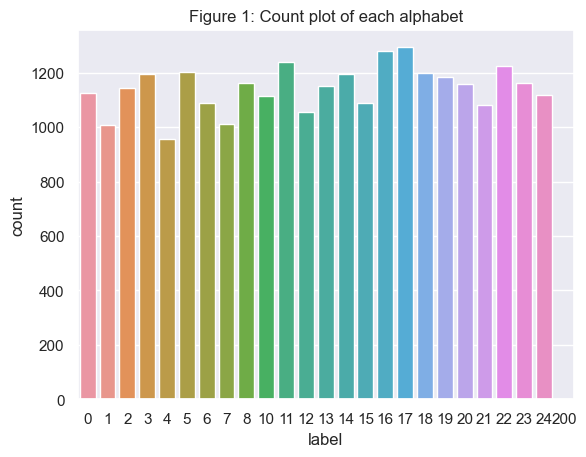

In [231]:
# Train dataset visualization

sns.set(style='darkgrid', context='notebook', palette='deep')
sns.countplot(x=train_hand_sign_df['label'].sort_values())
plt.title("Figure 1: Count plot of each alphabet")
plt.show()

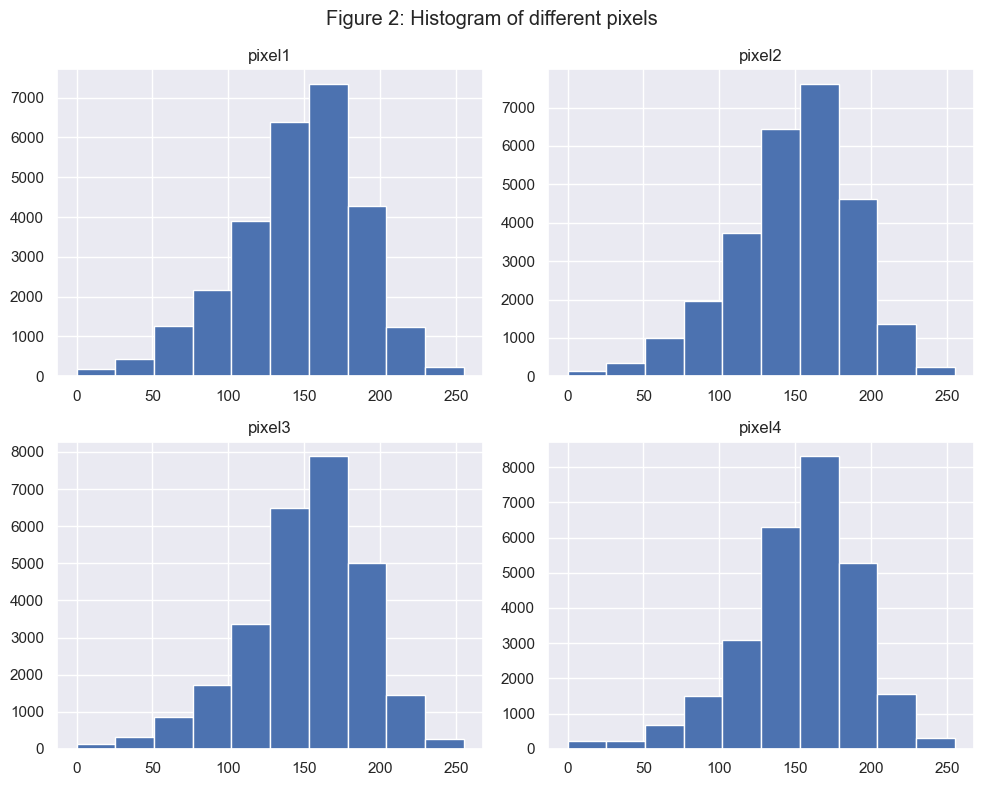

In [232]:
train_hand_sign_df.iloc[:,1:5].hist(figsize=(10, 8))
plt.suptitle('Figure 2: Histogram of different pixels')
plt.tight_layout()
plt.show()

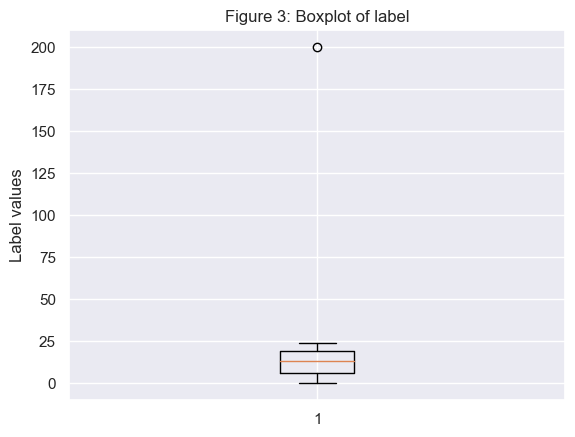

In [233]:
# Plotting the boxplot graph to show differnt values in Hour feature
plt.boxplot(train_hand_sign_df['label'])

# setting the y-axis values, labelling the axis and adding a title
#plt.yticks(np.arange(min(train_hand_sign_df['label']), max(train_hand_sign_df['label']) + 1, 1))
plt.ylabel('Label values')
plt.title('Figure 3: Boxplot of label')

# Displaying the plot
plt.show()

In [234]:
# Creating the correlation matrix for all the features
corr_mat = train_hand_sign_df.corr()

# Displaying the values corresponding to the target
corr_with_tgt = corr_mat['label'].sort_values(ascending=False)
print('Top 10 +ve correlation values of each feature vs the alphabets:', corr_with_tgt[1:10], sep='\n')

corr_with_tgt = corr_mat['label'].sort_values()
print('Top 10 -ve correlation values of each feature vs the alphabets:', corr_with_tgt[1:10], sep='\n')

Top 10 +ve correlation values of each feature vs the alphabets:
pixel348    0.319043
pixel320    0.300220
pixel321    0.296436
pixel376    0.296412
pixel322    0.289376
pixel349    0.286414
pixel347    0.284321
pixel350    0.279839
pixel292    0.277086
Name: label, dtype: float64
Top 10 -ve correlation values of each feature vs the alphabets:
pixel466   -0.260478
pixel467   -0.251859
pixel495   -0.247971
pixel493   -0.235765
pixel465   -0.235417
pixel522   -0.230892
pixel439   -0.214394
pixel438   -0.212671
pixel468   -0.211790
Name: label, dtype: float64


### 1.3 Preprocessing

In [235]:
# Performing data pre-processing

# Imputing invalid columns
#train_hand_sign_df['label'] = train_hand_sign_df['label'].where(train_hand_sign_df['label'] <= 25, np.nan)

train_hand_sign_df = train_hand_sign_df[train_hand_sign_df['label'] <= 25]
test_hand_sign_df = test_hand_sign_df[test_hand_sign_df['label'] <= 25]

# Converting the labels from numerical to alphabets
#train_hand_sign_df['label'] = train_hand_sign_df['label'].map({0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'J', 7:'H', 8:'I',
#                                                              9:'J', 10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q',
#                                                              17:'R', 18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X', 24:'Y',
#                                                              25:'Z'})


train_hand_sign_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Part 2
### 2.1 Splitting Dataset

In [308]:
from sklearn.model_selection import train_test_split

x_train = train_hand_sign_df.drop('label', axis=1)
y_train = train_hand_sign_df['label']

x_test = test_hand_sign_df.drop('label', axis=1)
y_test = test_hand_sign_df['label']

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

print("x shape:", x_train.shape, x_valid.shape, x_test.shape)
print("y shape:", y_train.shape, y_valid.shape, y_test.shape)

x shape: (27454, 784) (1435, 784) (5737, 784)
y shape: (27454,) (1435,) (5737,)


In [309]:
# Normalize the data
x_train = x_train.values/255
x_valid = x_valid.values/255
x_test = x_test.values/255
print(x_train)

[[0.41960784 0.4627451  0.49803922 ... 0.8        0.79607843 0.79215686]
 [0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 ...
 [0.68235294 0.68235294 0.68235294 ... 0.79215686 0.78431373 0.78431373]
 [0.69411765 0.70980392 0.72156863 ... 0.25098039 0.34117647 0.36470588]
 [0.70196078 0.70588235 0.70588235 ... 0.80392157 0.81960784 0.84313725]]


In [310]:
# Reshape the data to be shape [Nx, Ny, 1]
X_train = x_train.reshape((-1, 28, 28, 1)) # number of images, x_size, y_size, channels
X_valid = x_valid.reshape((-1, 28, 28, 1))
X_test = x_test.reshape((-1, 28, 28, 1))
print(X_train)

[[[[0.41960784]
   [0.4627451 ]
   [0.49803922]
   ...
   [0.66666667]
   [0.66666667]
   [0.6627451 ]]

  [[0.43529412]
   [0.4745098 ]
   [0.50588235]
   ...
   [0.67058824]
   [0.67058824]
   [0.66666667]]

  [[0.44313725]
   [0.48235294]
   [0.51372549]
   ...
   [0.67058824]
   [0.67058824]
   [0.67058824]]

  ...

  [[0.55686275]
   [0.58823529]
   [0.62352941]
   ...
   [0.79215686]
   [0.78823529]
   [0.78431373]]

  [[0.55686275]
   [0.59215686]
   [0.62745098]
   ...
   [0.8       ]
   [0.79607843]
   [0.79215686]]

  [[0.55686275]
   [0.59215686]
   [0.62745098]
   ...
   [0.8       ]
   [0.79607843]
   [0.79215686]]]


 [[[0.60784314]
   [0.61568627]
   [0.61176471]
   ...
   [0.54117647]
   [0.36078431]
   [0.42352941]]

  [[0.61960784]
   [0.62352941]
   [0.62352941]
   ...
   [0.55686275]
   [0.45490196]
   [0.56078431]]

  [[0.63137255]
   [0.63137255]
   [0.63137255]
   ...
   [0.57647059]
   [0.49019608]
   [0.54901961]]

  ...

  [[0.63529412]
   [0.62352941]
   [0.5

In [311]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=26)
y_valid = to_categorical(y_valid, num_classes=26)
y_test = to_categorical(y_test, num_classes=26)
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


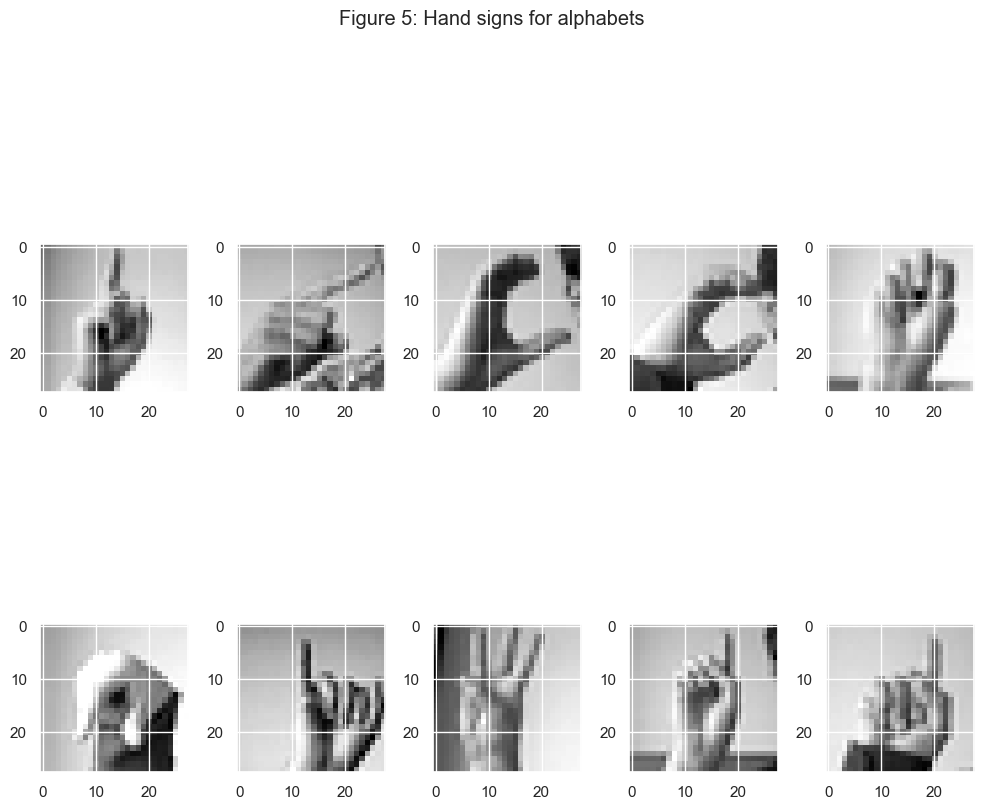

In [240]:
#Preview of first 10 images

f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1

plt.suptitle('Figure 5: Hand signs for alphabets')
plt.tight_layout()
plt.show()

### 2.2 Baseline creation

In [241]:
#Densely Connected Model

from keras.models import Sequential
from keras.layers import Dense, Flatten

# Build the densely connected model
print("Densely Connected Model")
model_dense = Sequential()
model_dense.add(Flatten(input_shape = (28, 28, 1))) #Flattening the unput shape to Nx1
model_dense.add(Dense(128, activation='relu')) # Adding a dense layer
model_dense.add(Dense(26, activation='softmax')) # Adding 2nd dense layer

# Compile the model
model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model_dense.summary()

Densely Connected Model
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_100 (Flatten)       (None, 784)               0         
                                                                 
 dense_328 (Dense)           (None, 128)               100480    
                                                                 
 dense_329 (Dense)           (None, 26)                3354      
                                                                 
Total params: 103834 (405.60 KB)
Trainable params: 103834 (405.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [242]:
# Train the model
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32)

Epoch 1/50
858/858 [==============================] - 2s 2ms/step - loss: 2.1787 - accuracy: 0.3744 - val_loss: 1.6798 - val_accuracy: 0.5087
Epoch 2/50
858/858 [==============================] - 2s 2ms/step - loss: 1.2772 - accuracy: 0.6282 - val_loss: 1.3208 - val_accuracy: 0.6181
Epoch 3/50
858/858 [==============================] - 2s 2ms/step - loss: 0.9702 - accuracy: 0.7150 - val_loss: 1.2023 - val_accuracy: 0.6146
Epoch 4/50
858/858 [==============================] - 2s 2ms/step - loss: 0.7907 - accuracy: 0.7658 - val_loss: 1.1463 - val_accuracy: 0.6355
Epoch 5/50
858/858 [==============================] - 2s 2ms/step - loss: 0.6500 - accuracy: 0.8154 - val_loss: 1.1367 - val_accuracy: 0.6544
Epoch 6/50
858/858 [==============================] - 2s 2ms/step - loss: 0.5494 - accuracy: 0.8455 - val_loss: 1.0204 - val_accuracy: 0.6934
Epoch 7/50
858/858 [==============================] - 2s 2ms/step - loss: 0.4671 - accuracy: 0.8720 - val_loss: 1.1504 - val_accuracy: 0.6537
Epoch 

In [243]:
score_dense = model_dense.evaluate(x_test,y_test,verbose=0)
print("Densely Connected model Baseline:")
print('Validation Loss : {:.4f}'.format(score_dense[0]))
print('Validation Accuracy : {:.4f}'.format(100*score_dense[1]))

Densely Connected model Baseline:
Validation Loss : 1.7751
Validation Accuracy : 70.9779


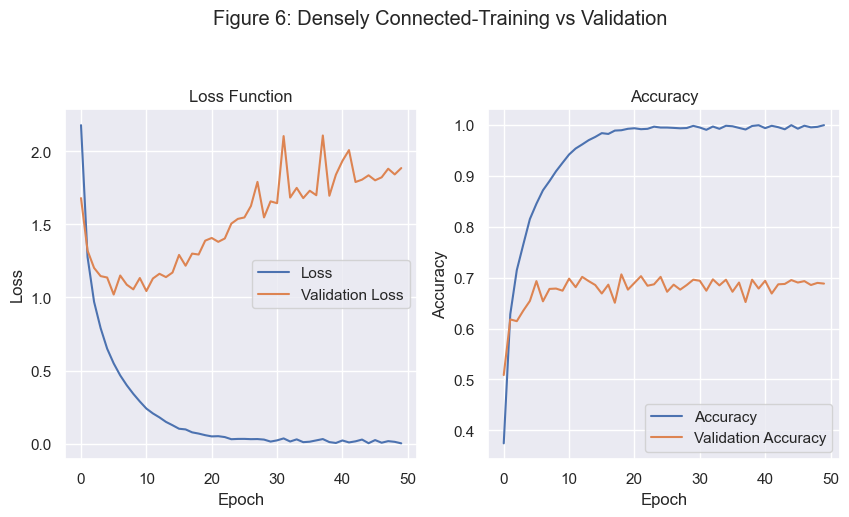

In [244]:
plt.figure(figsize=(10, 10))
plt.suptitle('Figure 6: Densely Connected-Training vs Validation')

plt.subplot(2, 2, 1)
plt.plot(history_dense.history['loss'], label='Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_dense.history['accuracy'], label='Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [245]:
# CNN model

from keras.layers import Conv2D, MaxPooling2D, Flatten

# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(26, activation='softmax'))

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the CNN model
model_cnn.summary()

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_101 (Flatten)       (None, 5408)              0         
                                                                 
 dense_330 (Dense)           (None, 26)                140634    
                                                                 
Total params: 140954 (550.60 KB)
Trainable params: 140954 (550.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [246]:
# Train the CNN model
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32)

Epoch 1/50
858/858 [==============================] - 5s 6ms/step - loss: 0.9802 - accuracy: 0.7656 - val_loss: 0.7240 - val_accuracy: 0.7575
Epoch 2/50
858/858 [==============================] - 6s 7ms/step - loss: 0.1295 - accuracy: 0.9854 - val_loss: 0.6000 - val_accuracy: 0.8237
Epoch 3/50
858/858 [==============================] - 6s 7ms/step - loss: 0.0376 - accuracy: 0.9994 - val_loss: 0.6547 - val_accuracy: 0.8237
Epoch 4/50
858/858 [==============================] - 6s 7ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.6596 - val_accuracy: 0.8314
Epoch 5/50
858/858 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.7244 - val_accuracy: 0.8341
Epoch 6/50
858/858 [==============================] - 5s 6ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7549 - val_accuracy: 0.8334
Epoch 7/50
858/858 [==============================] - 5s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8025 - val_accuracy: 0.8279
Epoch 

In [254]:
score_cnn = model_cnn.evaluate(X_test,y_test)
print("CNN model Baseline")
print('Validation Loss : {:.4f}'.format(score_cnn[0]))
print('Validation Accuracy : {:.4f}'.format(100*score_cnn[1]))

180/180 [==============================] - 0s 2ms/step - loss: 1.3040 - accuracy: 0.8459
CNN model Baseline
Validation Loss : 1.3040
Validation Accuracy : 84.5913


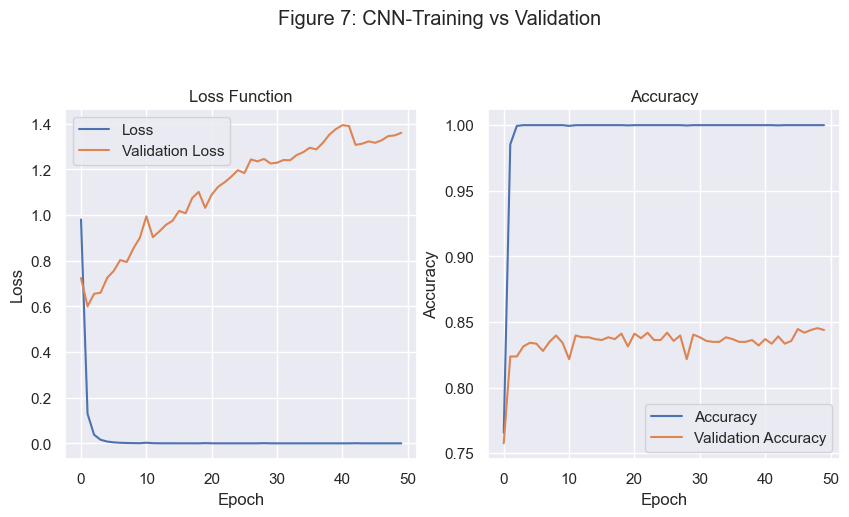

In [255]:
plt.figure(figsize=(10, 10))
plt.suptitle('Figure 7: CNN-Training vs Validation')

plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

## Part 3
### 3.1 Optimization

In [256]:
# Densely Connected Model
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model_dc_opt = Sequential()
    model_dc_opt.add(Flatten(input_shape = (28, 28, 1)))  # always have same sized inputs
    
    for n in hiddensizes:
        model_dc_opt.add(Dense(n, activation = actfn))    # Create as many layers 
    
    model_dc_opt.add(Dense(26, activation = "softmax"))   # always have 10 classes
    
    model_dc_opt.compile(loss="categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    
    return model_dc_opt

In [260]:
def do_all(model_name, hiddensizes, actfn, optimizer, learningrate):
    model = model_name(hiddensizes, actfn, optimizer, learningrate)
    
    history_dc_opt = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
    
    max_val_acc = np.max(history_dc_opt.history['val_accuracy'])
    
    return (max_val_acc, history_dc_opt, model)

In [261]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.show()

In [262]:
# Hyperparameters
hiddensizes = [32, 64, 32]
actfn = 'relu'
optimizer = optimizers.SGD
learningrate = 0.01

# Exploring Learning rate
res=[]
for lr in [1, 0.1, 0.01, 0.001, 0.0001]:
    valacc, history, discard = do_all(model_dense_factory, hiddensizes, actfn, optimizer, lr)
    res += [[lr,valacc]]

Epoch 1/20
858/858 [==============================] - 1s 1ms/step - loss: 3.2199 - accuracy: 0.0434 - val_loss: 3.2128 - val_accuracy: 0.0341
Epoch 2/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1854 - accuracy: 0.0441 - val_loss: 3.2037 - val_accuracy: 0.0293
Epoch 3/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1846 - accuracy: 0.0442 - val_loss: 3.2129 - val_accuracy: 0.0293
Epoch 4/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1836 - accuracy: 0.0470 - val_loss: 3.2078 - val_accuracy: 0.0202
Epoch 5/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1836 - accuracy: 0.0439 - val_loss: 3.2286 - val_accuracy: 0.0230
Epoch 6/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1840 - accuracy: 0.0425 - val_loss: 3.2141 - val_accuracy: 0.0432
Epoch 7/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1840 - accuracy: 0.0432 - val_loss: 3.2085 - val_accuracy: 0.0369
Epoch 

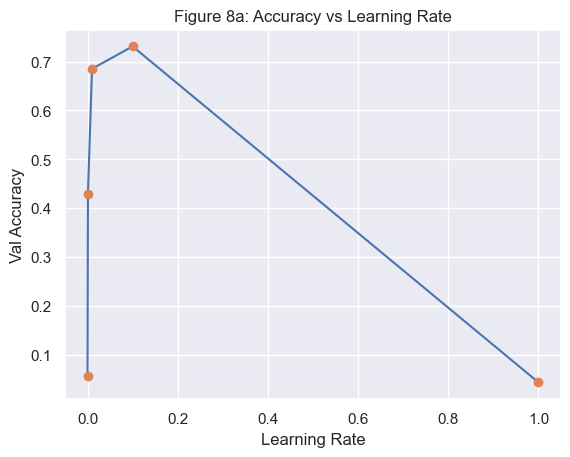

In [263]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.plot(res[:,0],res[:,1],'o')
plt.title('Figure 8a: Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Val Accuracy')
plt.show()

In [264]:
# Exploring number of layers
res=[]
for n in [1, 3, 5, 7, 9]:
    valacc, history, discard = do_all(model_dense_factory, hiddensizes[:n], actfn, optimizer, learningrate)
    #plot_history(history)
    res += [[n,valacc]]

Epoch 1/20
858/858 [==============================] - 1s 1ms/step - loss: 2.9661 - accuracy: 0.1554 - val_loss: 2.7362 - val_accuracy: 0.2132
Epoch 2/20
858/858 [==============================] - 1s 997us/step - loss: 2.3491 - accuracy: 0.3539 - val_loss: 2.1710 - val_accuracy: 0.3763
Epoch 3/20
858/858 [==============================] - 1s 1ms/step - loss: 1.8546 - accuracy: 0.4818 - val_loss: 1.8294 - val_accuracy: 0.4808
Epoch 4/20
858/858 [==============================] - 1s 992us/step - loss: 1.5582 - accuracy: 0.5555 - val_loss: 1.6467 - val_accuracy: 0.5024
Epoch 5/20
858/858 [==============================] - 1s 982us/step - loss: 1.3681 - accuracy: 0.6021 - val_loss: 1.5546 - val_accuracy: 0.5387
Epoch 6/20
858/858 [==============================] - 1s 981us/step - loss: 1.2278 - accuracy: 0.6393 - val_loss: 1.4264 - val_accuracy: 0.5638
Epoch 7/20
858/858 [==============================] - 1s 977us/step - loss: 1.1165 - accuracy: 0.6690 - val_loss: 1.3526 - val_accuracy: 0.6

Text(0, 0.5, 'Val Accuracy')

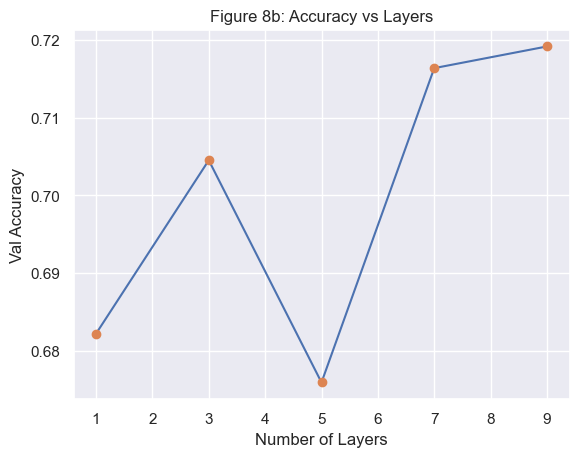

In [265]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.plot(res[:,0],res[:,1],'o')
plt.title('Figure 8b: Accuracy vs Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Val Accuracy')

In [281]:
# Exploring optimizers
res=[]
optimizer_setup = [[optimizers.SGD,0.01], [optimizers.Adam,0.01], [optimizers.RMSprop, 0.01], [optimizers.Nadam, 0.01]]
for optimizer,lr in optimizer_setup :
    valacc, history, discard = do_all(model_dense_factory, hiddensizes, actfn, optimizer, lr)
    #plot_history(history)
    res += [[valacc]]

Epoch 1/20
858/858 [==============================] - 1s 1ms/step - loss: 3.1701 - accuracy: 0.1010 - val_loss: 3.0662 - val_accuracy: 0.1171
Epoch 2/20
858/858 [==============================] - 1s 998us/step - loss: 2.5365 - accuracy: 0.2372 - val_loss: 2.2210 - val_accuracy: 0.3094
Epoch 3/20
858/858 [==============================] - 1s 1ms/step - loss: 1.9515 - accuracy: 0.3690 - val_loss: 1.8925 - val_accuracy: 0.3791
Epoch 4/20
858/858 [==============================] - 1s 1ms/step - loss: 1.6603 - accuracy: 0.4543 - val_loss: 1.7740 - val_accuracy: 0.4411
Epoch 5/20
858/858 [==============================] - 1s 996us/step - loss: 1.4507 - accuracy: 0.5207 - val_loss: 1.5302 - val_accuracy: 0.4962
Epoch 6/20
858/858 [==============================] - 1s 981us/step - loss: 1.2688 - accuracy: 0.5741 - val_loss: 1.4844 - val_accuracy: 0.5261
Epoch 7/20
858/858 [==============================] - 1s 1ms/step - loss: 1.1150 - accuracy: 0.6234 - val_loss: 1.3449 - val_accuracy: 0.5937


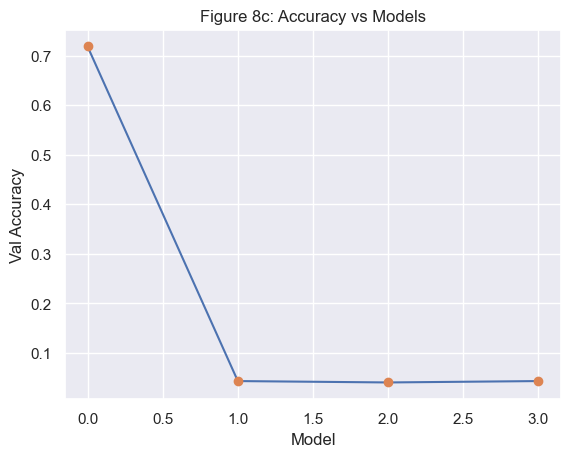

In [282]:
res=np.array(res)
plt.plot(res)
plt.plot(res,'o')
plt.title('Figure 8c: Accuracy vs Models')
plt.xlabel('Model')
plt.ylabel('Val Accuracy')
plt.show()

### From this, we can pick the best parameters for a Densely Connected model as learning_rate=0.01, hidden_layers=3, optimizer=SGD

In [283]:
# CNN model
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = Sequential()
    model.add(Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=(28, 28, 1)))    # input layer goes into this 2D convolution
    model.add(MaxPooling2D(pool_size=2))          # Pool (downsize)
    
    for n in hiddensizes[1:-1]:
        model.add(Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(MaxPooling2D(pool_size=2))          # Pool (downsize)
    
    model.add(Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(Flatten())                          # unravel into a 1D vector
    model.add(Dense(26, activation = "softmax"))  # always have 10 classes
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    
    return model

In [285]:
#Hyperparameters
hiddensizes = [32, 64, 32]
actfn = 'relu'
optimizer = optimizers.SGD

# Exploring learning rate
res=[]
for lr in [1, 0.1, 0.01, 0.001, 0.0001]:
    valacc, history, discard = do_all(model_cnn_factory, hiddensizes, actfn, optimizer, lr)
    res += [[lr*learningrate,valacc]]

Epoch 1/20
858/858 [==============================] - 13s 15ms/step - loss: 3.1925 - accuracy: 0.0443 - val_loss: 3.2194 - val_accuracy: 0.0460
Epoch 2/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1856 - accuracy: 0.0430 - val_loss: 3.2077 - val_accuracy: 0.0341
Epoch 3/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1840 - accuracy: 0.0466 - val_loss: 3.1887 - val_accuracy: 0.0341
Epoch 4/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1849 - accuracy: 0.0431 - val_loss: 3.2058 - val_accuracy: 0.0293
Epoch 5/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1841 - accuracy: 0.0438 - val_loss: 3.1994 - val_accuracy: 0.0341
Epoch 6/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1842 - accuracy: 0.0423 - val_loss: 3.2028 - val_accuracy: 0.0348
Epoch 7/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1841 - accuracy: 0.0439 - val_loss: 3.2061 - val_accuracy:

Text(0, 0.5, 'Val Accuracy')

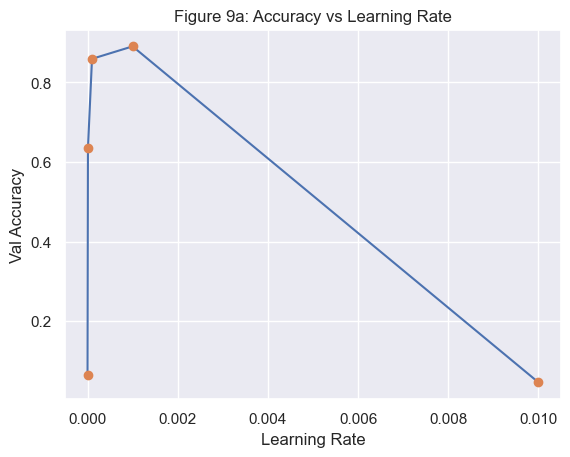

In [286]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.plot(res[:,0],res[:,1],'o')
plt.title('Figure 9a: Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Val Accuracy')

In [288]:
# Exploring number of layers
res=[]
hiddensizes=[32, 64, 32]
#Taking best learning rate from above
for n in [1, 3, 5, 7, 9]:
    valacc, history, discard = do_all(model_cnn_factory, hiddensizes[:n], actfn, optimizer, 0.001)
    #plot_history(history)
    res += [[n,valacc]]

Epoch 1/20
858/858 [==============================] - 9s 10ms/step - loss: 3.1852 - accuracy: 0.0563 - val_loss: 3.1596 - val_accuracy: 0.0474
Epoch 2/20
858/858 [==============================] - 9s 10ms/step - loss: 3.0832 - accuracy: 0.1409 - val_loss: 3.0367 - val_accuracy: 0.1233
Epoch 3/20
858/858 [==============================] - 8s 10ms/step - loss: 2.8303 - accuracy: 0.2497 - val_loss: 2.6660 - val_accuracy: 0.2355
Epoch 4/20
858/858 [==============================] - 8s 9ms/step - loss: 2.3024 - accuracy: 0.3515 - val_loss: 2.0955 - val_accuracy: 0.4181
Epoch 5/20
858/858 [==============================] - 8s 10ms/step - loss: 1.9009 - accuracy: 0.4265 - val_loss: 1.8439 - val_accuracy: 0.4300
Epoch 6/20
858/858 [==============================] - 9s 11ms/step - loss: 1.6628 - accuracy: 0.4791 - val_loss: 1.7017 - val_accuracy: 0.4836
Epoch 7/20
858/858 [==============================] - 10s 12ms/step - loss: 1.5013 - accuracy: 0.5309 - val_loss: 1.6086 - val_accuracy: 0.4941

Epoch 18/20
858/858 [==============================] - 12s 15ms/step - loss: 0.7831 - accuracy: 0.7571 - val_loss: 1.1007 - val_accuracy: 0.6341
Epoch 19/20
858/858 [==============================] - 13s 15ms/step - loss: 0.7188 - accuracy: 0.7758 - val_loss: 0.9967 - val_accuracy: 0.6627
Epoch 20/20
858/858 [==============================] - 13s 15ms/step - loss: 0.6590 - accuracy: 0.7940 - val_loss: 0.9916 - val_accuracy: 0.6544
Epoch 1/20
858/858 [==============================] - 13s 15ms/step - loss: 3.2472 - accuracy: 0.0523 - val_loss: 3.2387 - val_accuracy: 0.0460
Epoch 2/20
858/858 [==============================] - 12s 14ms/step - loss: 3.2090 - accuracy: 0.0704 - val_loss: 3.2156 - val_accuracy: 0.0460
Epoch 3/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1774 - accuracy: 0.0676 - val_loss: 3.1954 - val_accuracy: 0.0390
Epoch 4/20
858/858 [==============================] - 12s 14ms/step - loss: 3.1554 - accuracy: 0.0927 - val_loss: 3.1797 - val_accura

Text(0, 0.5, 'Val Accuracy')

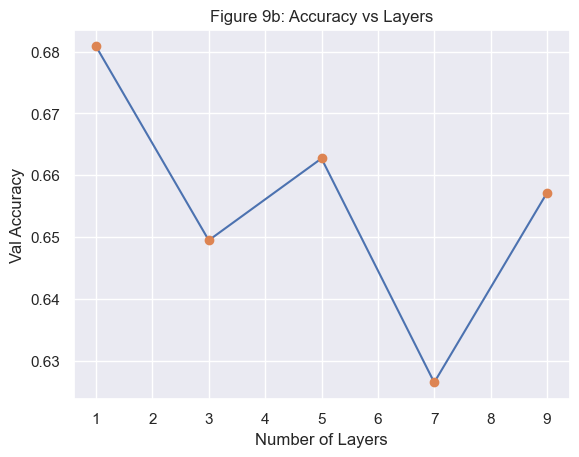

In [289]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.plot(res[:,0],res[:,1],'o')
plt.title('Figure 9b: Accuracy vs Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Val Accuracy')

In [296]:
# Exploring optimizers
res=[]
#Taking best learning rate and number of layers from above
hiddensizes=[32]
optimizer_setup = [[optimizers.SGD,0.001], [optimizers.Adam,0.001], [optimizers.RMSprop, 0.001], [optimizers.Nadam, 0.001]]
for optimizer,lr in optimizer_setup :
    valacc, history, discard = do_all(model_cnn_factory, hiddensizes, actfn, optimizer, lr)
    #plot_history(history)
    res += [[valacc]]

Epoch 1/20
858/858 [==============================] - 11s 13ms/step - loss: 3.2185 - accuracy: 0.0421 - val_loss: 3.1990 - val_accuracy: 0.0334
Epoch 2/20
858/858 [==============================] - 11s 12ms/step - loss: 3.1513 - accuracy: 0.0817 - val_loss: 3.1473 - val_accuracy: 0.0355
Epoch 3/20
858/858 [==============================] - 11s 12ms/step - loss: 3.0555 - accuracy: 0.1496 - val_loss: 2.9904 - val_accuracy: 0.1679
Epoch 4/20
858/858 [==============================] - 11s 13ms/step - loss: 2.7586 - accuracy: 0.2664 - val_loss: 2.5736 - val_accuracy: 0.2711
Epoch 5/20
858/858 [==============================] - 11s 13ms/step - loss: 2.2281 - accuracy: 0.3597 - val_loss: 2.1367 - val_accuracy: 0.3596
Epoch 6/20
858/858 [==============================] - 11s 13ms/step - loss: 1.8556 - accuracy: 0.4300 - val_loss: 1.9005 - val_accuracy: 0.4474
Epoch 7/20
858/858 [==============================] - 11s 12ms/step - loss: 1.6408 - accuracy: 0.4857 - val_loss: 1.6946 - val_accuracy:

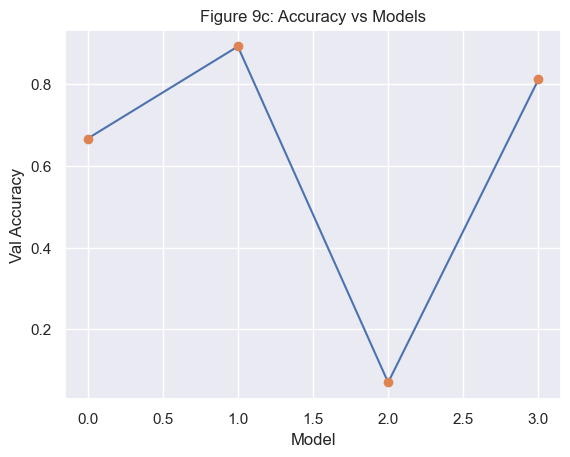

In [297]:
res=np.array(res)
plt.plot(res)
plt.plot(res,'o')
plt.title('Figure 9c: Accuracy vs Models')
plt.xlabel('Model')
plt.ylabel('Val Accuracy')
plt.show()

## Part 4
### 4.1 Comparison of models

In [316]:
print(y_train.shape)
print(y_test.shape)
print(y_pred.shape)
print(y_true.shape)

(27454, 26)
(5737, 26)
(5737,)
(5737,)


In [317]:
# Densely Connected model predictions
from sklearn.metrics import classification_report,confusion_matrix

hiddensizes = [32, 64, 32]
actfn = 'relu'
optimizer = optimizers.SGD
learningrate = 0.001
final_dn_model = model_dense_factory(hiddensizes, actfn, optimizer, learningrate)
predictions = final_dn_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

y_true = np.argmax(y_test, axis=1)

classes = ["Class " + str(i) for i in range(25) if i!= 9]
print(classification_report(y_true, y_pred, target_names = classes))

              precision    recall  f1-score   support

     Class 0       0.06      1.00      0.12       265
     Class 1       0.00      0.00      0.00       345
     Class 2       0.03      0.04      0.03       248
     Class 3       0.00      0.00      0.00       196
     Class 4       0.00      0.00      0.00       398
     Class 5       0.02      0.10      0.03       198
     Class 6       0.00      0.00      0.00       278
     Class 7       0.00      0.00      0.00       349
     Class 8       0.00      0.00      0.00       230
    Class 10       0.00      0.00      0.00       265
    Class 11       0.00      0.00      0.00       167
    Class 12       0.00      0.00      0.00       315
    Class 13       0.00      0.00      0.00       233
    Class 14       0.00      0.00      0.00       197
    Class 15       0.00      0.00      0.00       277
    Class 16       0.00      0.00      0.00       131
    Class 17       0.00      0.00      0.00       115
    Class 18       0.00    

In [318]:
# CNN model predictions
hiddensizes = [32]
actfn = 'relu'
optimizer = optimizers.Adam
learningrate = 0.001
final_cnn_model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
predictions = final_cnn_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y_true, y_pred, target_names = classes))

180/180 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       265
     Class 1       0.00      0.00      0.00       345
     Class 2       0.00      0.00      0.00       248
     Class 3       0.00      0.00      0.00       196
     Class 4       0.00      0.00      0.00       398
     Class 5       0.03      1.00      0.07       198
     Class 6       0.00      0.00      0.00       278
     Class 7       0.00      0.00      0.00       349
     Class 8       0.00      0.00      0.00       230
    Class 10       0.00      0.00      0.00       265
    Class 11       0.00      0.00      0.00       167
    Class 12       0.00      0.00      0.00       315
    Class 13       0.00      0.00      0.00       233
    Class 14       0.00      0.00      0.00       197
    Class 15       0.00      0.00      0.00       277
    Class 16       0.00      0.00      0.00       131
    Class 17       0.00   

In [319]:
test_score_df = final_dn_model.evaluate(X_test,y_test)
print("Densely Connected model Test Accuracy :",100*test_score_df[1])

test_score_cnn = final_cnn_model.evaluate(X_test,y_test)
print("CNN model Test Accuracy :",100*test_score_cnn[1])

180/180 [==============================] - 0s 1ms/step - loss: 3.2947 - accuracy: 0.0514
Densely Connected model Test Accuracy : 5.142060294747353
180/180 [==============================] - 1s 5ms/step - loss: 3.2571 - accuracy: 0.0345
CNN model Test Accuracy : 3.451281040906906


### Based on the above data, CNN model is better as it has better accuracy although it takes more time to run than Densely Connected model

In [320]:
#Letter with lowest accuracy

from sklearn.metrics import accuracy_score

predictions = final_cnn_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

class_accuracies = []
for i in range(25):  # num_classes is the total number of classes (letters)
    class_indices = np.where(y_test == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_test[class_indices]
    class_acc = accuracy_score(class_true, class_pred)
    class_accuracies.append((i, class_acc))

class_accuracies.sort(key=lambda x: x[1])
lowest_letter, lowest_accuracy = class_accuracies[0]
print(f"Letter with the Lowest Accuracy: {chr(lowest_letter + 65)} (Class {lowest_letter}), Accuracy: {lowest_accuracy * 100:.2f}%")


180/180 [==============================] - 1s 4ms/step
Letter with the Lowest Accuracy: A (Class 0), Accuracy: 0.00%


In [321]:
#Most common error

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

most_common_errors = []

for true_class in range(0,24):
    for pred_class in range(0,24):
        if true_class != pred_class:
            most_common_errors.append((true_class, pred_class, conf_matrix[true_class][pred_class]))

most_common_errors.sort(key=lambda x: x[2], reverse=True)
most_common_error = most_common_errors[0]
print(f"Most Common Error: Predicted {chr(most_common_error[1] + 65)} instead of {chr(most_common_error[0] + 65)}, Count: {most_common_error[2]}")


Most Common Error: Predicted F instead of E, Count: 398
